In [1]:
import numpy as np
import operator
import matplotlib.pyplot as plt
import time

import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')

try:
    import cplex
    from cplex.exceptions import CplexError
except: 
    print("Warning: Cplex not found.")
import math

In [2]:
class Initializer():

    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

In [3]:
class ClassicalOptimizer:

    def __init__(self, instance,n,K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles


    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n-self.K)


    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0])+[0. for x in range(0,n-1)]
        my_ub = [1 for x in range(0,n**2+n-1)]
        my_lb = [0 for x in range(0,n**2)] + [0.1 for x in range(0,n-1)]
        my_ctype = "".join(['I' for x in range(0,n**2)]) + "".join(['C' for x in range(0,n-1)])

        my_rhs = 2*([K] + [1 for x in range(0,n-1)]) + [1-0.1 for x in range(0,(n-1)**2-(n-1))] + [0 for x in range(0,n)]
        my_sense = "".join(['E' for x in range(0,2*n)]) + "".join(['L' for x in range(0,(n-1)**2-(n-1))])+"".join(['E' for x in range(0,n)])

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x,cost
    

    def populatebyrow(self,prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs):

        n = self.n
    
        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj = my_obj, lb = my_lb, ub = my_ub, types = my_ctype)
    
        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0,n):
            col = [x for x in range(0+n*ii,n+n*ii)]
            coef = [1 for x in range(0,n)]
            rows.append([col, coef])

        for ii in range(0,n):
            col = [x for x in range(0+ii,n**2,n)]
            coef = [1 for x in range(0,n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0,n):
                if (ii != jj)and(ii*jj>0):

                    col = [ii+(jj*n), n**2+ii-1, n**2+jj-1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0,n):
            col = [(ii)*(n+1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [4]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()    

#clients = 4 and #cars = 2
Number of feasible solutions = 10.0


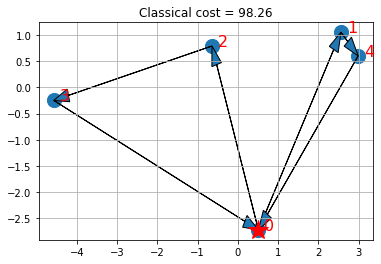



#clients = 6 and #cars = 3
Number of feasible solutions = 35.0


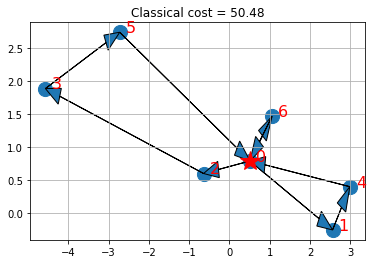



#clients = 8 and #cars = 4
Number of feasible solutions = 126.0


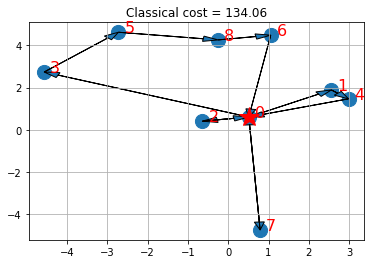



#clients = 10 and #cars = 5
Number of feasible solutions = 462.0


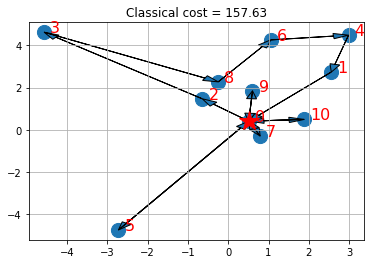



#clients = 12 and #cars = 6
Number of feasible solutions = 1716.0


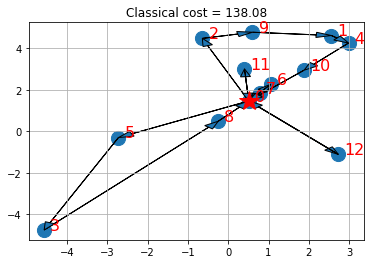



#clients = 14 and #cars = 7
Number of feasible solutions = 6435.0


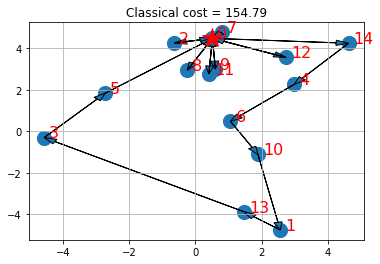



#clients = 16 and #cars = 8
Number of feasible solutions = 24310.0


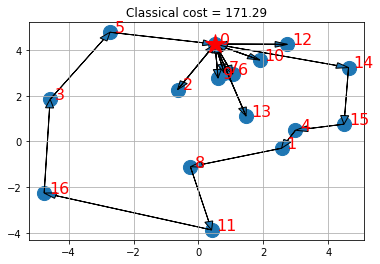



#clients = 18 and #cars = 9
Number of feasible solutions = 92378.0


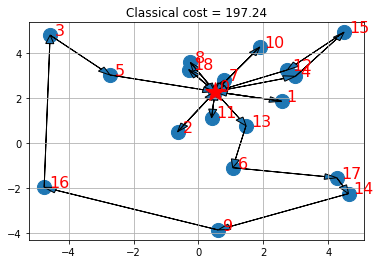

In [5]:
build_time = []
solve_time = []
for K in range(2,10,1):
    n = 2*K
    n = n+1
    print(f"#clients = {n-1} and #cars = {K}")
    initializer = Initializer(n)
    xc,yc,instance = initializer.generate_instance()

    # Instantiate the classical optimizer class
    t1 = time.time()
    classical_optimizer = ClassicalOptimizer(instance,n,K)
    t2 = time.time() - t1
    build_time.append(t2)
    # Print number of feasible solutions
    print('Number of feasible solutions = ' + str(classical_optimizer.compute_allowed_combinations()))
    
    # Solve the problem in a classical fashion via CPLEX
    x = None
    z = None
    try:
        t3 = time.time()
        x,classical_cost = classical_optimizer.cplex_solution()
        t4 = time.time() - t3
        solve_time.append(t4)
        # Put the solution in the z variable
        z = [x[ii] for ii in range(n**2) if ii//n != ii%n]
        # Print the solution
#         print(z)
    except: 
        print("CPLEX may be missing.")
    visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')
    print('\n')


In [6]:
for t in build_time:
    print(t)

5.245208740234375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
1.3828277587890625e-05
6.4373016357421875e-06
7.3909759521484375e-06
6.9141387939453125e-06


In [7]:
for t in solve_time:
    print(t)

21.42236852645874
32.561763525009155
20.426445245742798
9.413358688354492
7.247113943099976
58.93157434463501
51.173686265945435
125.20686745643616


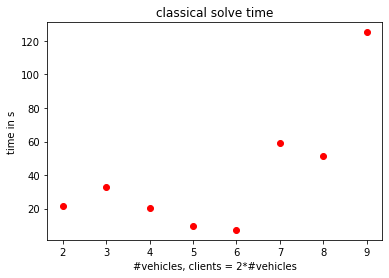

In [8]:
import matplotlib.pyplot as plt
plt.plot(range(2,10), [t for t in solve_time], 'ro')
plt.title('classical solve time')
plt.xlabel("#vehicles, clients = 2*#vehicles")
plt.ylabel("time in s")
plt.show()

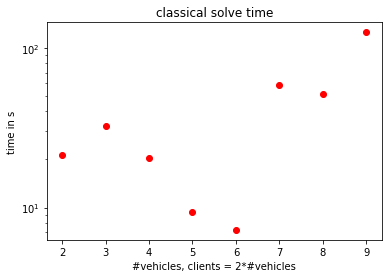

In [9]:
plt.plot(range(2,10), [t for t in solve_time], 'ro')
plt.yscale('log')
plt.title('classical solve time')
plt.xlabel("#vehicles, clients = 2*#vehicles")
plt.ylabel("time in s")
plt.show()

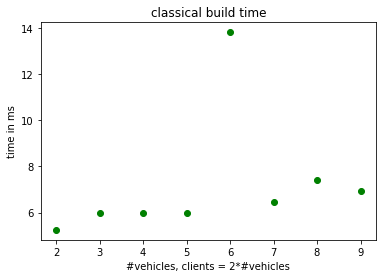

In [11]:
plt.plot(range(2,10), [t*1e6 for t in build_time], 'go')
plt.title('classical build time')
plt.xlabel("#vehicles, clients = 2*#vehicles")
plt.ylabel("time in ms")
plt.show()

In [ ]:
plt.plot(range(2,10), [t*1e6 for t in build_time], 'go')
plt.yscale('LOG')
plt.title('classical build time')
plt.xlabel("#vehicles, clients = 2*#vehicles")
plt.ylabel("time in ms")
plt.show()